In [1]:
from gates import *
from states import *
from measurements import *
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

In [2]:
batch_size = 128
n_photons = 20
num_params = 6
num_iteration = 1000
initial_state = np.zeros((batch_size, n_photons))
initial_state[:, 0] = 1.#/np.sqrt(3.)
# initial_state[:, 2] = 1./np.sqrt(3.)
# initial_state[:, 3] = 1./np.sqrt(3.)
params = np.zeros(num_params)
# gamma, r1, phi1, r2, phi2, theta1
lr = 1e-1 # learning rate

In [3]:
def circuit(init_state, params, batch_size, num_params, lr, n_photons):
    random_numbers = lr*np.random.randn(num_params*batch_size).reshape(batch_size, num_params)
    gate1 = V_gate(params[0] + random_numbers[:,0], n_photons)   # cubic gate
    gate2 = S_gate(params[1] + random_numbers[:,1], params[2] + random_numbers[:,2], n_photons) # squeezing
    gate3 = D_gate(params[3] + random_numbers[:,3], params[4] + random_numbers[:,4], n_photons) # displacement
    gate4 = R_gate(params[5] + random_numbers[:,5], n_photons) # rotation
    state = np.einsum('ijk,ik->ij', gate1, init_state)
    state = np.einsum('ijk,ik->ij', gate2, state)
    state = np.einsum('ijk,ik->ij', gate3, state)
    state = np.einsum('ijk,ik->ij', gate4, state)
    data_X = meas_X(state, n_photons)
    data_P = meas_P(state, n_photons)
    return random_numbers, data_X, data_P

def mean_moment(quadrature):
    return np.mean(quadrature, axis=1)

def calc_loss(X, P):
    X_mean = mean_moment(X)
    P_mean = mean_moment(P)
    return X_mean**2 + P_mean**2# + P_mean**4 + X_mean**4


In [4]:
# R, X, P = circuit(initial_state, params, batch_size, num_params, n_photons)

In [5]:
for i in range(num_iteration):
    lr = lr *0.99
    rand_num, X, P = circuit(initial_state, params, batch_size, num_params, lr, n_photons)
    loss = calc_loss(X, P)
    if i%10 ==0: print("Iteration = {} --- loss_value {}".format(i, np.mean(loss)))
    loss = (loss - np.mean(loss))/(np.std(loss)+1e-8)
    for j in range(6):
        params[j] -= lr/batch_size*loss.dot(rand_num[:,j])

Iteration = 0 --- loss_value 0.02313028264346096
Iteration = 10 --- loss_value 0.02558563853283581
Iteration = 20 --- loss_value 0.011973405653667698
Iteration = 30 --- loss_value 0.010014470543896505
Iteration = 40 --- loss_value 0.00867570648436981
Iteration = 50 --- loss_value 0.009673278439060651
Iteration = 60 --- loss_value 0.006121538985637484
Iteration = 70 --- loss_value 0.006207156945578064
Iteration = 80 --- loss_value 0.0041295420200093275
Iteration = 90 --- loss_value 0.0030132900564520592
Iteration = 100 --- loss_value 0.003126470952468545
Iteration = 110 --- loss_value 0.0026304986339182376
Iteration = 120 --- loss_value 0.0019473529811489855
Iteration = 130 --- loss_value 0.0020446248962807502
Iteration = 140 --- loss_value 0.0016067214723895556
Iteration = 150 --- loss_value 0.0009614408208664227
Iteration = 160 --- loss_value 0.0010039513018813596
Iteration = 170 --- loss_value 0.0008492043340136522
Iteration = 180 --- loss_value 0.0006847707194384033
Iteration = 190 

KeyboardInterrupt: 

In [6]:
def test(params, init_state):
    gate1 = V_gate(params[0], n_photons)   # cubic gate
    gate2 = S_gate(params[1], params[2], n_photons) # squeezing
    gate3 = D_gate(params[3], params[4], n_photons) # displacement
    gate4 = R_gate(params[5], n_photons) # rotation
    state = np.einsum('ijk,ik->ij', gate1, init_state)
    state = np.einsum('ijk,ik->ij', gate2, state)
    state = np.einsum('ijk,ik->ij', gate3, state)
    state = np.einsum('ijk,ik->ij', gate4, state)
    return state.reshape(state.shape[1],1)

In [7]:
init_state = np.zeros((1, n_photons))
init_state[:,0] = 1./np.sqrt(3.)
init_state[:,2] = 1./np.sqrt(3.)
init_state[:,3] = 1./np.sqrt(3.)
new_state = test(params, init_state)
rho = np.kron(new_state,new_state.conj().T)

Final_state


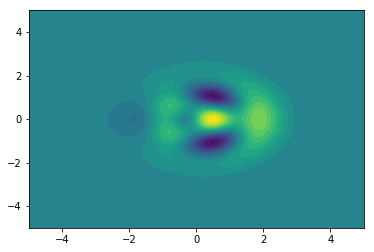

In [8]:
print("Final_state")
xvec = np.linspace(-5,5,200)
W = wigner_iterative(rho, xvec, xvec)
cont0 = plt.contourf(xvec, xvec, W, 20)
plt.show()

Initial_state


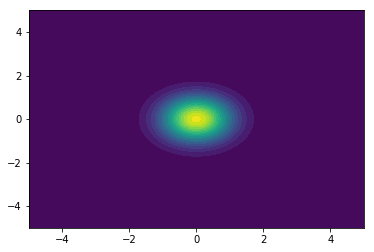

In [9]:
print("Initial_state")
init_state = np.zeros((1, n_photons))
init_state[:,0] = 1.
init_state = init_state.reshape(init_state.shape[1],1)
rho = np.kron(new_state,init_state.conj().T)
xvec = np.linspace(-5,5,200)
W = wigner_iterative(rho, xvec, xvec)
cont0 = plt.contourf(xvec, xvec, W, 20)
plt.show()

In [10]:
state = init_state.reshape(1,init_state.shape[0])
data_X = meas_X(state, n_photons)
data_P = meas_P(state, n_photons)